# Spectral clustering -- cluster quality

Spectral clustering arguably approximates the ratio cut objective:
$$
\min_{C_1,\ldots, C_k}\sum_{i=1}^k\frac{w(\partial C)}{|C|}
$$
How well does spectral clustering approximate the objective? *On the quality of spectral separators*, Guaterry and Miller (1998) shows that the approximation can be arbitrarily bad.

## Spectral clustering algorithm

Unfortunately, networkx does not provide spectral clustering. scikit-learn has an implementation, which, however, is based on the normalised Laplacian. Therefore, we implement here our own spectral clustering algorithm.

In [1]:
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy

class SpecCluster:
    def __init__(self,G,n_clusters):
        self.n_clusters=n_clusters
        self.G=G
        self.__spectral_embedding()
        self.__cluster()

    def __spectral_embedding(self):
        ## not the best implementation
        # compute eigenvectors and -values
        L=nx.laplacian_matrix(self.G).astype("float")
        res=scipy.sparse.linalg.eigsh(L,k=self.n_clusters,which="SM")
        # sort by size
        evs=res[1]/np.linalg.norm(res[1],axis=0)
        ## don't really need to return first dim, we do it anyway
        self.embedding=evs

    def __cluster(self):
        ## run KMeans on the spectral embedding
        km=KMeans(n_clusters=self.n_clusters,init="random",n_init=10)
        self.clustering=km.fit_predict(self.embedding)        

    def get_clustering(self):
        C=[[] for _ in range(self.n_clusters)]
        for node,cluster_index in zip(self.G.nodes,self.clustering):
            C[cluster_index].append(node)
        return C

    def out_edges(self,C):
        return len(list(nx.edge_boundary(self.G,C)))

    def ratio_cut(self):
        """computes ratio cut objective of the clustering"""
        return sum([self.out_edges(C)/len(C) for C in self.get_clustering()])

To see that the code works, let's cluster a stochastic block model. 

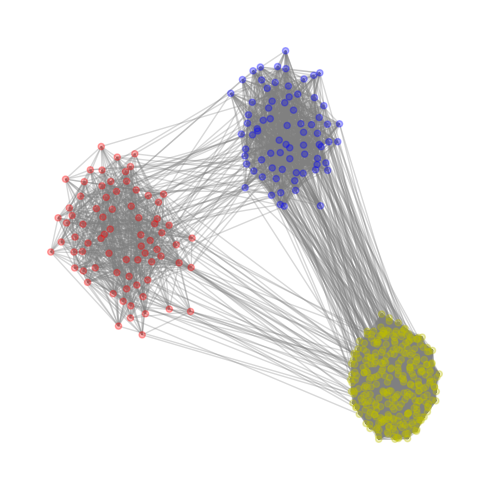

In [2]:
## define random graph with three clusters
sizes = [75, 75, 300]
probs = [[0.25, 0.01, 0.002], [0.01, 0.35, 0.007], [0.002, 0.007, 0.40]]
G = nx.stochastic_block_model(sizes, probs)

def colour_map(c):
    if c==0:
        return 'b'
    if c==1:
        return 'r'
    return 'y'

clusters=SpecCluster(G,3).clustering
colours=[colour_map(c) for c in clusters]
pos=nx.spring_layout(G)

fig,ax=plt.subplots(figsize=(5,5))
ax.axis("off")
nx.draw_networkx(G,pos=pos,node_size=20,with_labels=False,alpha=0.3,node_color=colours,ax=ax,edge_color="grey")
plt.tight_layout()


## Guattery-Miller graphs

Guattery and Miller construct, for every $k$, a graph $G_k$ of size $>2^k$ such that the ratio 
$$
\frac{\text{RatioCut}(\text{SpectralClustering}(G_k))}{\text{OPT}}\to\infty
$$

The graphs $G_k$ are the Cartesian product of a 3-regular tree and a path, where the sizes of the tree and the path are roughly 
$$
4\sqrt{|\text{tree}|}\approx |\text{path}|
$$

(By the way, there's also a simpler family of counterexamples in the Guaterry-Miller paper, roach graphs -- that family, however, does not work for k-means clustering of the spectral embedding.)

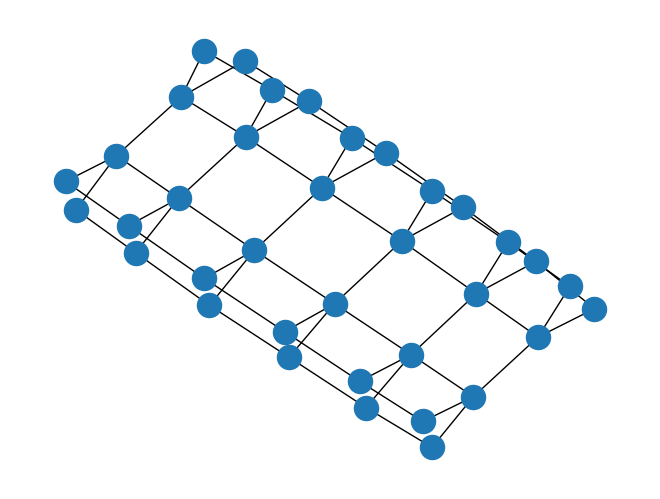

In [3]:
import math
def double_tree(height):
    tree1=nx.balanced_tree(2,height)
    tree2=nx.balanced_tree(2,height)
    dtree=nx.disjoint_union_all([tree1,tree2])
    second_root=nx.number_of_nodes(tree2)
    dtree.add_edge(0,second_root)
    return dtree

def tree_cross_path(tree_height,path_length):
    DT=double_tree(tree_height)
    path=nx.path_graph(path_length+1)
    return nx.cartesian_product(DT,path)

def guattery_miller_graph(k):
    # tree_height=k-1
    # p=2**k-2
    # path_length= math.floor(4*math.sqrt(p))
    tree_height=k-1
    path_length = math.floor(4*math.sqrt(2**k-2))
    return tree_cross_path(tree_height,path_length)

nx.draw(guattery_miller_graph(2))

## Measure clustering quality

The optimal ratio cut into two clusters of a Guaterry-Miller graph cuts along the path, and thus has a cut size that is equal to the number of vertices in the path. We can easily compute the optimal ratio cut.

In [4]:
def opt_gm_ratio_cut(k):
    path_length = math.floor(4*math.sqrt(2**k-2))
    size=(2**(k+1)-2)*(path_length+1)
    return 2*(path_length+1)/(0.5*size)

opt_gm_ratio_cut(3)

0.2857142857142857

We compare the optimal values to the ratio cuts returned by spectral clustering. Unfortunately, the running time of my implementation of spectral clustering increases rapidly with $k$, so that I can only compute a few values.

In [9]:
rcs=np.array([(SpecCluster(guattery_miller_graph(k),2).ratio_cut(),opt_gm_ratio_cut(k),k) for k in range(2,9)])
rcs

array([[6.66666667e-01, 6.66666667e-01, 2.00000000e+00],
       [4.00000000e-01, 2.85714286e-01, 3.00000000e+00],
       [2.67857143e-01, 1.33333333e-01, 4.00000000e+00],
       [1.81818182e-01, 6.45161290e-02, 5.00000000e+00],
       [1.25000000e-01, 3.17460317e-02, 6.00000000e+00],
       [8.89328063e-02, 1.57480315e-02, 7.00000000e+00],
       [6.25000000e-02, 7.84313725e-03, 8.00000000e+00]])

Text(0.5, 1.0, 'RatioCut: spectral clustering / OPT')

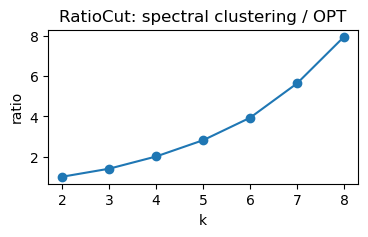

In [10]:
_,ax=plt.subplots(figsize=(4,2))
ax.plot(rcs[:,2],rcs[:,0]/rcs[:,1],"o-")
ax.set_xlabel("k")
ax.set_ylabel("ratio")
ax.set_title("RatioCut: spectral clustering / OPT")